In [1]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import GCNConv
from torchdyn.core import NeuralODE
from dataclasses import dataclass

from PIL import Image, ImageDraw, ImageFont
from pathlib import Path

import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from models import SkipMLP 
from models import GlobalGNN


# Data

In [2]:
class letters_replica_batch_dataset(Dataset):
    def __init__(
        self, noise_scale=0.05, source_noise_scale=0.5, num_rotations=10,
        ivp_batch_size=None, mode="train", seed=0,
    ):
        self.noise_scale = noise_scale
        self.source_noise_scale = source_noise_scale
        self.num_rotations = num_rotations
        self.ivp_batch_size = ivp_batch_size
        self.mode = mode
        self.alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
            
        self.samples = self._get_denoising_samples(mode, num_rotations, seed)
        self.num_samples = len(self.samples)

    def char_sampler(self, char, font_size=100, rotation=0.0):
        # Try to use system fonts available on macOS
        font_paths = [
            "/System/Library/Fonts/Arial.ttf",
            "/System/Library/Fonts/Helvetica.ttc", 
            "/System/Library/Fonts/Times.ttc"
        ]
        
        font = None
        for font_path in font_paths:
            if Path(font_path).exists():
                try:
                    font = ImageFont.truetype(font_path, font_size)
                    break
                except:
                    continue
        
        # Fallback to default font if no system font found
        if font is None:
            font = ImageFont.load_default()
            
        img = Image.new('L', (2*font_size, 2*font_size), color=0)
        d = ImageDraw.Draw(img)
        d.text((font_size/2, font_size/2), char, fill=255, font=font)
        img = np.array(img)
        
        mask = img > 0
        samples = np.argwhere(mask)
        samples = torch.from_numpy(samples).float()
        
        samples -= samples.min(0).values
        samples /= samples.max()
        samples = (samples * 2 - 1) * 3.0
        
        samples += self.noise_scale * torch.randn_like(samples)
        
        M = torch.tensor([
            [np.cos(rotation), -np.sin(rotation)],
            [np.sin(rotation), np.cos(rotation)]
        ], dtype=samples.dtype)
        samples = samples @ M.T
        return samples

    def _get_denoising_samples(self, mode, num_rotations, seed):
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        samples = []
        if mode == 'train':
            letters_to_use = [c for c in self.alphabet if c not in ('X', 'Y')]
        elif mode == 'val':
            letters_to_use = ['X']
        elif mode == "test":
            letters_to_use = ['Y']
        else:
            raise ValueError('Invalid mode')

        for target_char in letters_to_use:
            for _ in range(num_rotations):
                rotation = 2.0 * torch.pi * torch.rand(1).item()
                target_samples = self.char_sampler(target_char, rotation=rotation)
                source_samples = target_samples + self.source_noise_scale * torch.randn_like(target_samples)
                samples.append((source_samples, target_samples))
        return samples

    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        source, target = self.samples[idx]
        if self.ivp_batch_size is not None:
            s_idx = np.random.choice(np.arange(source.shape[0]), size=self.ivp_batch_size, replace=False)
            t_idx = np.random.choice(np.arange(target.shape[0]), size=self.ivp_batch_size, replace=False)
            source, target = source[s_idx], target[t_idx]
        return idx, source, target

class LettersBatchDatamodule(pl.LightningDataModule):
    def __init__(self, batch_size=1, ivp_batch_size=512, num_rotations=10, **kwargs):
        super().__init__()
        self.save_hyperparameters(logger=True)
        self.train_dataset = letters_replica_batch_dataset(mode="train", ivp_batch_size=ivp_batch_size, num_rotations=num_rotations)
        self.val_dataset = letters_replica_batch_dataset(mode="val", ivp_batch_size=ivp_batch_size, num_rotations=num_rotations)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.hparams.batch_size, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.hparams.batch_size, shuffle=False)
    def predict_dataloader(self):
        return self.val_dataloader()

# Model

In [3]:
class TorchWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, t, x, *args, **kwargs):
        return self.model(t, x)

class LettersMFM(pl.LightningModule):
    def __init__(self, flow_lr: float = 1e-3, gnn_lr: float = 1e-3, **model_kwargs):
        super().__init__()
        self.automatic_optimization = False
        self.save_hyperparameters()
        self.model = GlobalGNN(**model_kwargs)
        self.embeddings = {}

    def configure_optimizers(self):
        flow_optimizer = torch.optim.Adam(self.model.decoder.parameters(), lr=self.hparams.flow_lr)
        gnn_optimizer = torch.optim.Adam(self.model.gcn_convs.parameters(), lr=self.hparams.gnn_lr)
        return flow_optimizer, gnn_optimizer

    def _shared_step(self, batch, use_cached_embedding: bool = True):
        idx, x0, x1 = batch
        idx_item = idx.item()

        if use_cached_embedding and idx_item in self.embeddings:
            embedding = self.embeddings[idx_item]
        else:
            embedding = self.model.embed_source(x0)
            self.embeddings[idx_item] = embedding.detach()

        t = torch.rand_like(x0[..., 0, None])
        y = (1.0 - t) * x0 + t * x1
        u = x1 - x0
        
        v = self.model.flow(embedding, t, y)
        loss = F.mse_loss(v, u)
        return loss

    def training_step(self, batch, batch_idx):
        flow_opt, gnn_opt = self.optimizers()
        
        # Reshape batch from [1, N, D] to [N, D] as we use batch_size=1
        idx, x0, x1 = batch[0], batch[1].squeeze(0), batch[2].squeeze(0)
        batch = (idx, x0, x1)

        if (batch_idx + 1) % 2 == 0:
            loss = self._shared_step(batch, use_cached_embedding=False)
            gnn_opt.zero_grad()
            self.manual_backward(loss)
            gnn_opt.step()
            self.log("train/gnn_loss", loss, prog_bar=True)
        else:
            loss = self._shared_step(batch, use_cached_embedding=True)
            flow_opt.zero_grad()
            self.manual_backward(loss)
            flow_opt.step()
            self.log("train/flow_loss", loss, prog_bar=True)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        idx, x0, x1 = batch[0], batch[1], batch[2]
        self.model.update_embedding_for_inference(x0)
        node = NeuralODE(TorchWrapper(self.model), solver='dopri5', atol=1e-4, rtol=1e-4)
        time_span = torch.linspace(0, 1, 100).to(self.device)
        
        with torch.no_grad():
            trajectory = node.trajectory(x0.squeeze(0), t_span=time_span)
        return {"trajectory": trajectory.cpu(), "source": x0.cpu(), "target": x1.cpu()}

In [4]:
# Hyperparameters
NUM_EPOCHS = 50
IVP_BATCH_SIZE = 512 # Number of points to sample from each letter
NUM_ROTATIONS = 5    # Number of random rotations per letter

# Setup Data
datamodule = LettersBatchDatamodule(ivp_batch_size=IVP_BATCH_SIZE, num_rotations=NUM_ROTATIONS)

# Setup Model
model = LettersMFM(
    flow_lr=1e-4, gnn_lr=1e-4, D=2, num_hidden_gnn=128, num_layers_gnn=3,
    num_hidden_decoder=256, num_layers_decoder=4, t_embedding_dim=128, knn_k=20
)

# Setup Trainer
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS, accelerator="auto", devices=1,
    enable_checkpointing=False, logger=False, enable_progress_bar=True
)

print("--- Starting Training ---")
trainer.fit(model, datamodule)
print("--- Training Finished ---")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/flow_matching/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | GlobalGNN | 330 K  | train
--------------------------------------------
330 K     Trainable params
0         Non-trainable params
330 K     Total params
1.321     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/flow_matching/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name  | Type      | Params | Mode 
--

--- Starting Training ---


/opt/anaconda3/envs/flow_matching/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


--- Training Finished ---


# Visualization

In [5]:
def visualize_results(predictions):
    num_plots = min(len(predictions), 5) # Plot up to 5 examples
    fig, axes = plt.subplots(num_plots, 6, figsize=(18, 3 * num_plots))
    if num_plots == 1: axes = np.array([axes])
    plt.suptitle("Learned Transformations (Source -> Target)", fontsize=16)

    for i in range(num_plots):
        pred = predictions[i]
        traj, source, target = pred['trajectory'], pred['source'].squeeze(0), pred['target'].squeeze(0)
        time_indices = [0, 25, 50, 75, -1]
        titles = ["Source (t=0)", "t=0.25", "t=0.5", "t=0.75", "Predicted (t=1)", "Ground Truth"]

        for j, t_idx in enumerate(time_indices):
            ax = axes[i, j]
            ax.scatter(traj[t_idx, :, 0], traj[t_idx, :, 1], s=5, alpha=0.7, color="#3283FB")
            ax.set_title(titles[j])
        
        axes[i, -1].scatter(target[:, 0], target[:, 1], s=5, alpha=0.7, color="green")
        axes[i, -1].set_title(titles[-1])

        for ax in axes[i]:
            ax.set_xlim(-4, 4); ax.set_ylim(-4, 4)
            ax.set_xticks([]); ax.set_yticks([]); ax.set_aspect('equal', adjustable='box')

    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

In [6]:
def visualize_detailed_flow(predictions, max_plots=3):
    """Visualize flow with more time steps to analyze integration quality"""
    num_plots = min(len(predictions), max_plots)
    fig, axes = plt.subplots(num_plots, 8, figsize=(24, 3 * num_plots))
    if num_plots == 1: axes = np.array([axes])
    plt.suptitle("Detailed Flow Analysis - More Time Steps", fontsize=16)

    for i in range(num_plots):
        pred = predictions[i]
        traj, source, target = pred['trajectory'], pred['source'].squeeze(0), pred['target'].squeeze(0)
        
        # More detailed time indices
        time_indices = [0, 12, 25, 37, 50, 62, 75, -1]  # Corresponds to t=0, 0.12, 0.25, 0.37, 0.5, 0.62, 0.75, 1.0
        titles = ["t=0.0", "t=0.12", "t=0.25", "t=0.37", "t=0.50", "t=0.62", "t=0.75", "t=1.0"]

        for j, t_idx in enumerate(time_indices[:-1]):  # All except the last one
            ax = axes[i, j]
            ax.scatter(traj[t_idx, :, 0], traj[t_idx, :, 1], s=3, alpha=0.7, color="#3283FB")
            ax.set_title(titles[j])
            ax.set_xlim(-4, 4); ax.set_ylim(-4, 4)
            ax.set_xticks([]); ax.set_yticks([])
            ax.set_aspect('equal', adjustable='box')
        
        # Ground truth in the last column
        axes[i, -1].scatter(target[:, 0], target[:, 1], s=3, alpha=0.7, color="green")
        axes[i, -1].set_title("Ground Truth")
        axes[i, -1].set_xlim(-4, 4); axes[i, -1].set_ylim(-4, 4)
        axes[i, -1].set_xticks([]); axes[i, -1].set_yticks([])
        axes[i, -1].set_aspect('equal', adjustable='box')

    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

def compare_early_stopping(predictions, stop_times=[0.3, 0.5, 0.7, 1.0]):
    """Compare results when stopping integration at different times"""
    num_plots = min(len(predictions), 2)
    fig, axes = plt.subplots(num_plots, len(stop_times) + 1, figsize=(6 * (len(stop_times) + 1), 3 * num_plots))
    if num_plots == 1: axes = np.array([axes])
    plt.suptitle("Early Stopping Analysis - Which t gives best results?", fontsize=16)

    for i in range(num_plots):
        pred = predictions[i]
        traj, source, target = pred['trajectory'], pred['source'].squeeze(0), pred['target'].squeeze(0)
        
        for j, stop_t in enumerate(stop_times):
            # Convert stop_time to trajectory index (trajectory has 100 steps from 0 to 1)
            t_idx = int(stop_t * (traj.shape[0] - 1))
            
            ax = axes[i, j]
            ax.scatter(traj[t_idx, :, 0], traj[t_idx, :, 1], s=5, alpha=0.7, color="#3283FB")
            ax.set_title(f"t={stop_t}")
            ax.set_xlim(-4, 4); ax.set_ylim(-4, 4)
            ax.set_xticks([]); ax.set_yticks([])
            ax.set_aspect('equal', adjustable='box')
        
        # Ground truth
        axes[i, -1].scatter(target[:, 0], target[:, 1], s=5, alpha=0.7, color="green")
        axes[i, -1].set_title("Ground Truth")
        axes[i, -1].set_xlim(-4, 4); axes[i, -1].set_ylim(-4, 4)
        axes[i, -1].set_xticks([]); axes[i, -1].set_yticks([])
        axes[i, -1].set_aspect('equal', adjustable='box')

    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()


--- Generating Predictions on Validation Set (Letter 'X') ---


/opt/anaconda3/envs/flow_matching/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

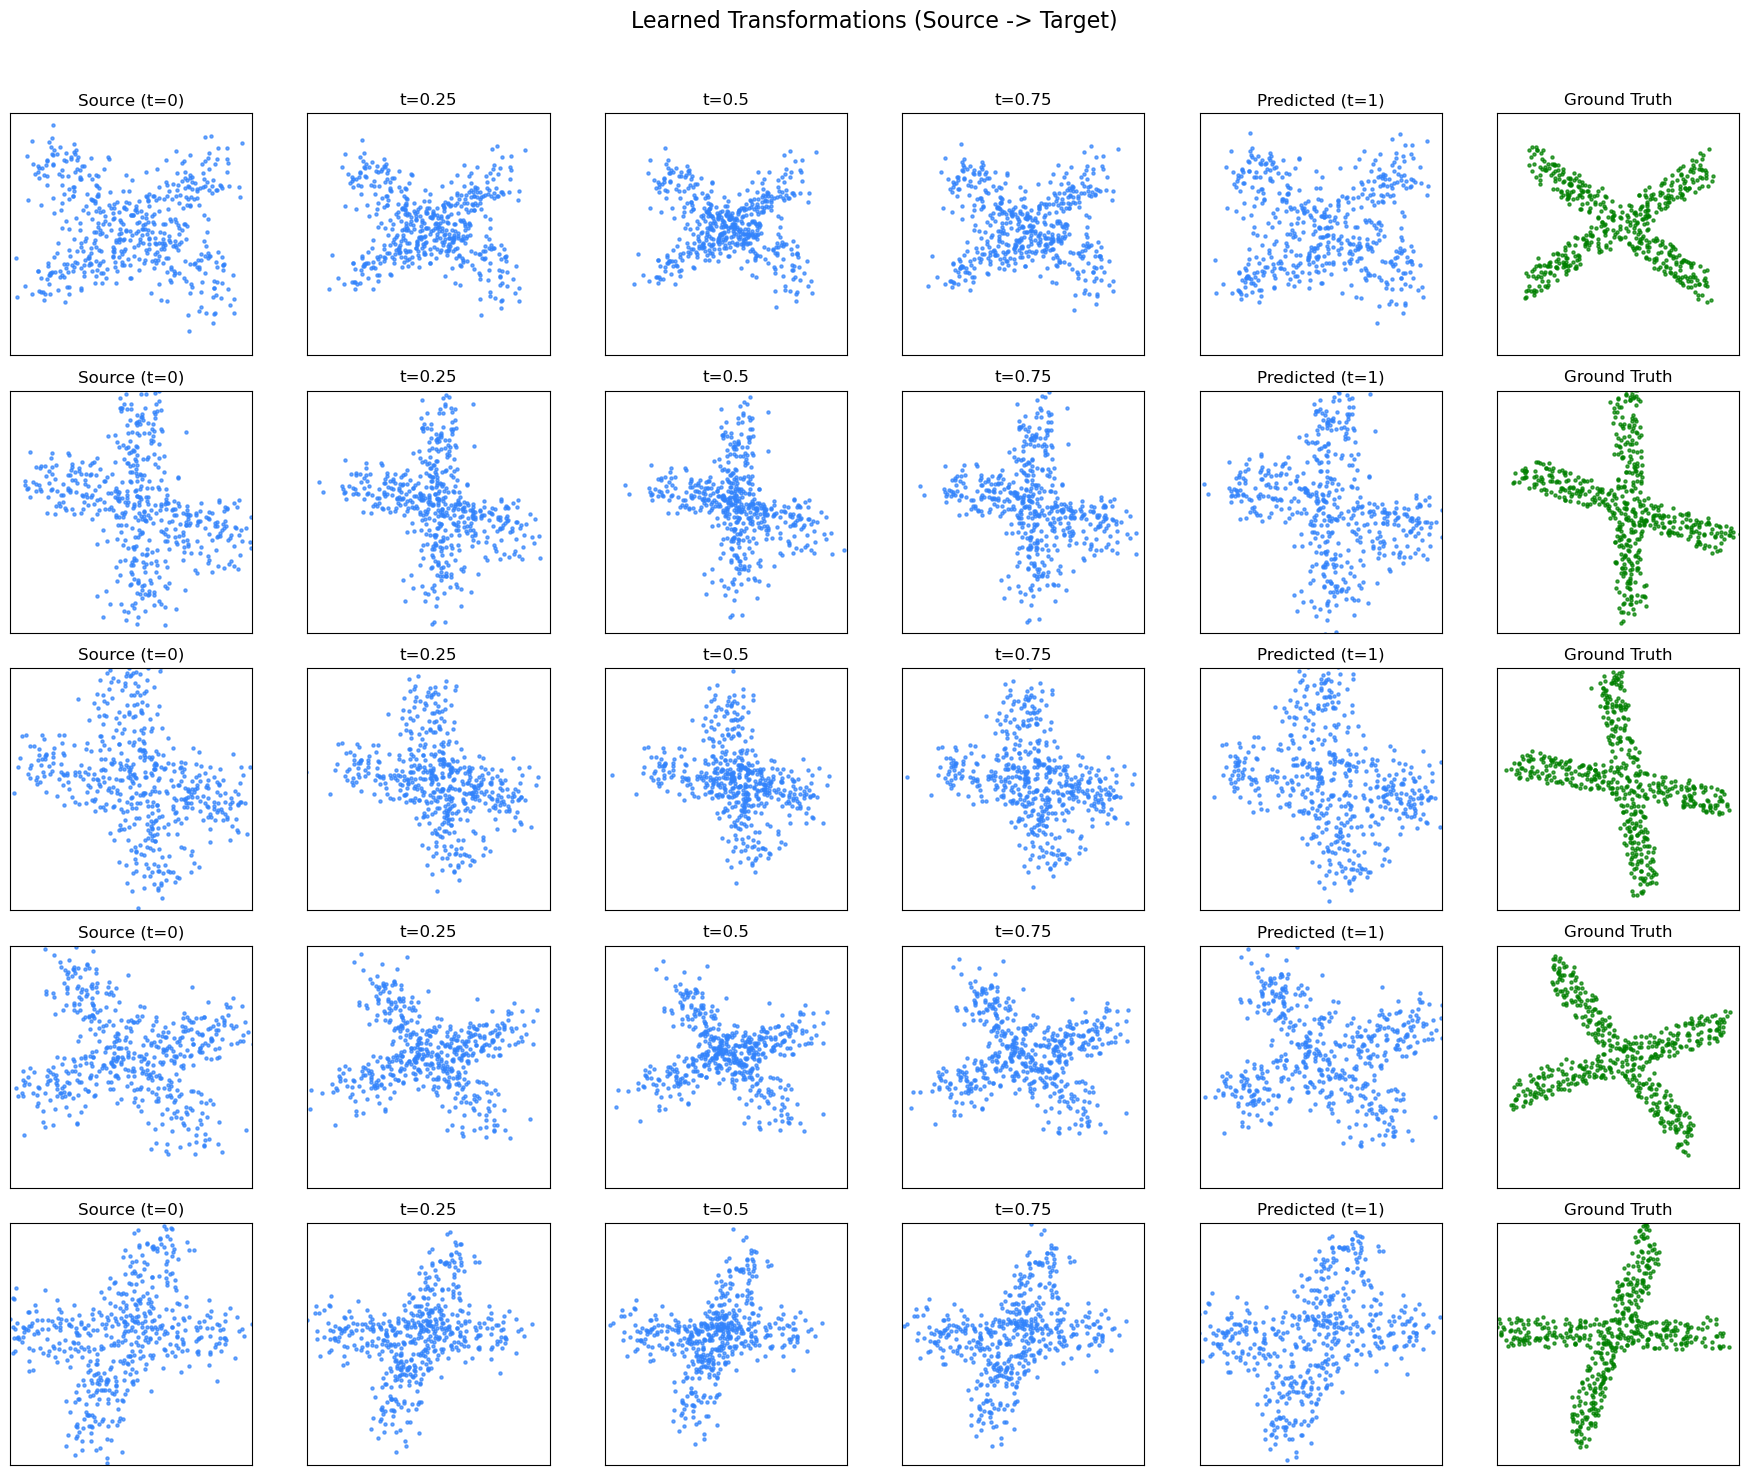

In [7]:
print("\n--- Generating Predictions on Validation Set (Letter 'X') ---")
predictions = trainer.predict(model, datamodule)

visualize_results(predictions)

=== Detailed Flow Analysis ===


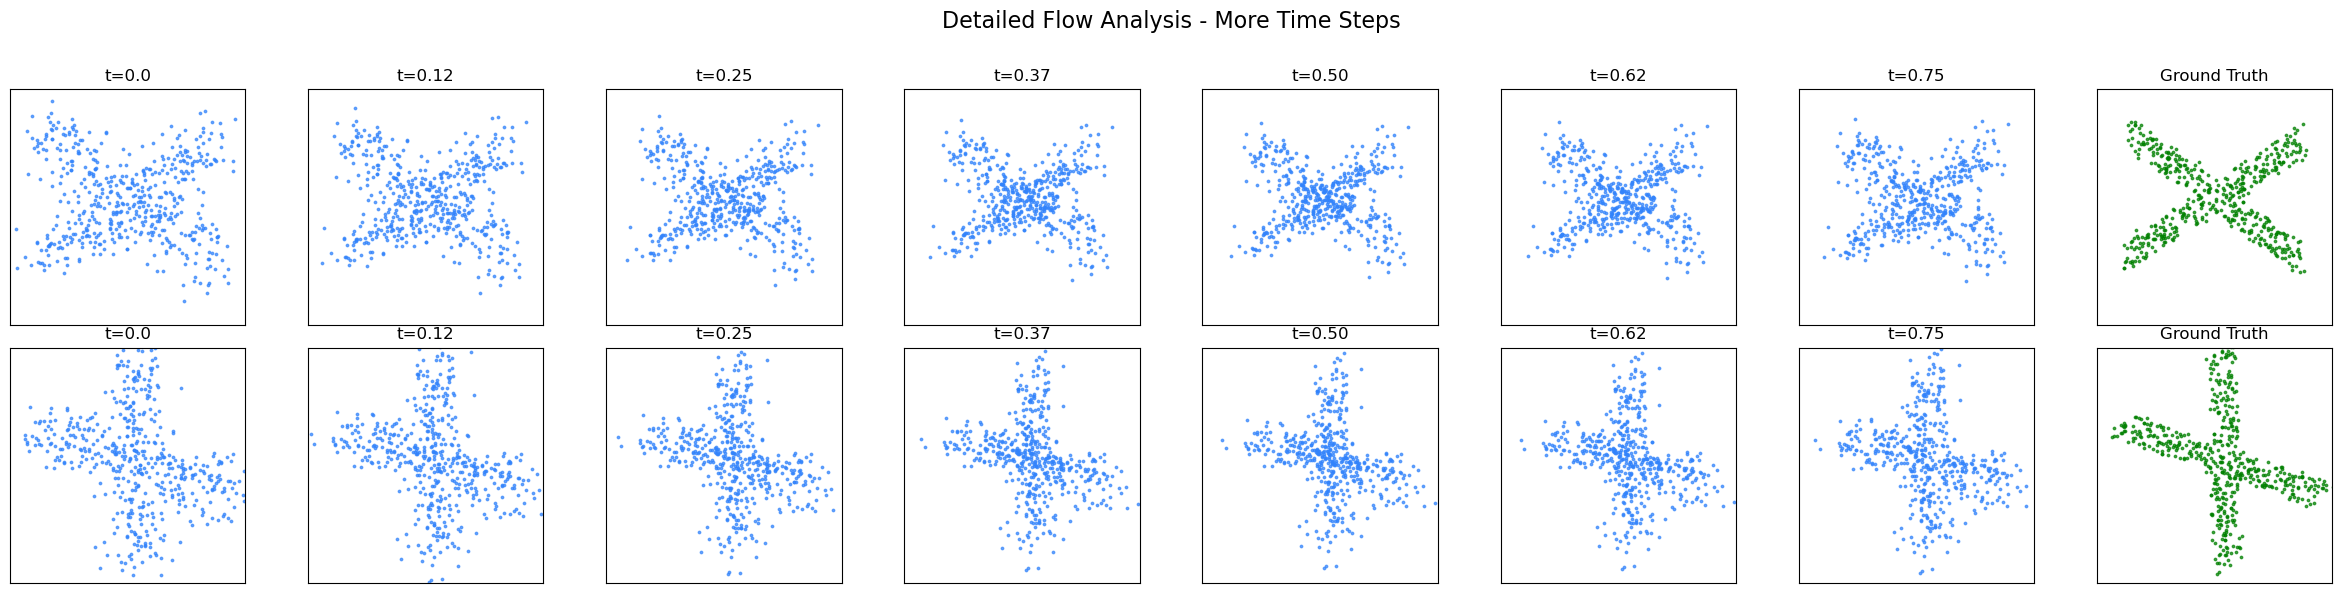


=== Early Stopping Analysis ===


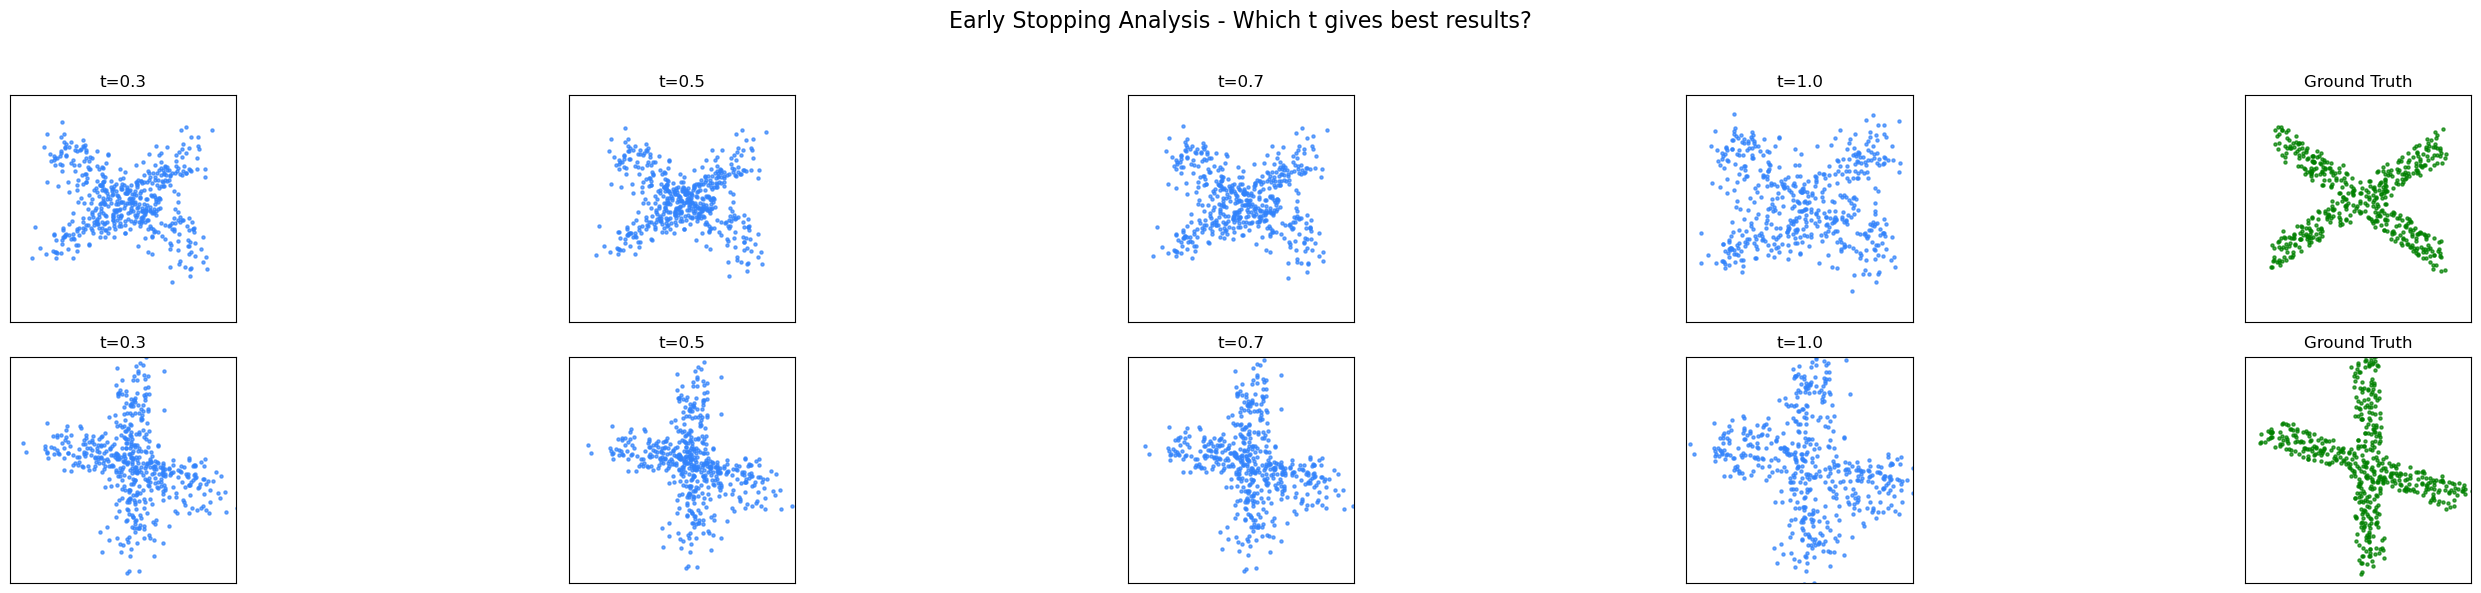

In [8]:
# Detailed analysis of the flow quality
print("=== Detailed Flow Analysis ===")
visualize_detailed_flow(predictions, max_plots=2)

print("\n=== Early Stopping Analysis ===")
compare_early_stopping(predictions, stop_times=[0.3, 0.5, 0.7, 1.0])